In [3]:
# Important Libraries
import numpy as np
import pandas as pd
import torch
import transformers
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import os


In [4]:
# Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
# Load your dataset
df = pd.read_csv("Roman_Urdu1.csv", encoding="latin1")

# Convert labels to numeric format
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
df.head()

,tweets,label
0,14 crore ke project ko banaa ke 14 arab khaa ...,0
1,Abhi bari hojao phir siyasat ki baat karna,0
2,Allah aap ko sehat zindagi dy taky aap choron...,0
3,antiii bhaii full gussy m h,0
4,Beshak bahar se parh ke aaya ho lekin bilawal...,0


In [6]:
# Define the custom dataset class
class RomanUrduDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt",
            truncation=True,
        )

        return {
            "text": text,
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.long),
        }


In [12]:
# Define Hyperparameters and Data Splitting
# Define hyperparameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 15

# Split dataset into train, validation, and test
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['tweets'].values, df['label'].values, test_size=0.3, random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

# Create dataloaders
train_dataset = RomanUrduDataset(train_texts, train_labels, tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = RomanUrduDataset(val_texts, val_labels, tokenizer, MAX_LEN)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = RomanUrduDataset(test_texts, test_labels, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Define Training and Evaluation Functions

import time
from tqdm import tqdm

# To store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Define training function
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(data_loader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total

    return avg_loss, accuracy

# Define evaluation function
def eval_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total

    return avg_loss, accuracy

# Define test function
def test_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total

    return avg_loss, accuracy


In [14]:
# Define evaluation function with detailed metrics
def evaluate_model(model, data_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)

    return accuracy, precision, recall, f1, conf_matrix, report


In [15]:
# Implement the Training Loop with Checkpoints
# Training loop with saving checkpoints
start_epoch = 0

# Load the checkpoint if exists
checkpoint_path = "checkpoint.pth"
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    train_accuracies = checkpoint['train_accuracies']
    val_accuracies = checkpoint['val_accuracies']

for epoch in range(start_epoch, EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    start_time = time.time()
    train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = eval_model(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
    }, checkpoint_path)

    end_time = time.time()
    print(f"Epoch duration: {(end_time - start_time):.2f} seconds")


Epoch 12/15


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 94/94 [08:15<00:00,  5.27s/it]


Training Loss: 0.0139, Training Accuracy: 0.9954
Validation Loss: 0.4266, Validation Accuracy: 0.9173
Epoch duration: 6415.24 seconds
Epoch 13/15


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 94/94 [07:22<00:00,  4.71s/it]


Training Loss: 0.0085, Training Accuracy: 0.9976
Validation Loss: 0.4454, Validation Accuracy: 0.9193
Epoch duration: 6100.81 seconds
Epoch 14/15


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 94/94 [10:17<00:00,  6.57s/it]


Training Loss: 0.0149, Training Accuracy: 0.9944
Validation Loss: 0.3447, Validation Accuracy: 0.9253
Epoch duration: 6389.97 seconds
Epoch 15/15


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 94/94 [08:33<00:00,  5.47s/it]


Training Loss: 0.0134, Training Accuracy: 0.9940
Validation Loss: 0.4055, Validation Accuracy: 0.9240
Epoch duration: 8545.79 seconds


In [16]:
# Evaluate the model on the test set after training is complete
test_loss, test_accuracy = test_model(model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 94/94 [07:02<00:00,  4.49s/it]

Test Loss: 0.3752, Test Accuracy: 0.9347


In [17]:
# Evaluate the model on the test set after training is complete
test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix, test_report = evaluate_model(model, test_loader, device)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1:.4f}")
print("Test Classification Report:")
print(test_report)
print("Test Confusion Matrix:")
print(test_conf_matrix)


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 94/94 [07:09<00:00,  4.57s/it]

Test Accuracy: 0.9347
Test Precision: 0.9347
Test Recall: 0.9347
Test F1-score: 0.9347
Test Classification Report:
              precision    recall  f1-score   support

           H       0.94      0.93      0.94       776
           N       0.93      0.94      0.93       724

    accuracy                           0.93      1500
   macro avg       0.93      0.93      0.93      1500
weighted avg       0.93      0.93      0.93      1500

Test Confusion Matrix:
[[724  52]
 [ 46 678]]


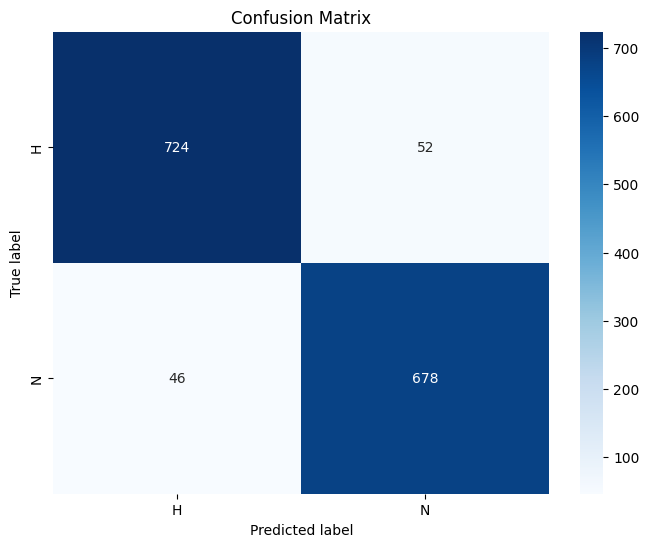

In [18]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


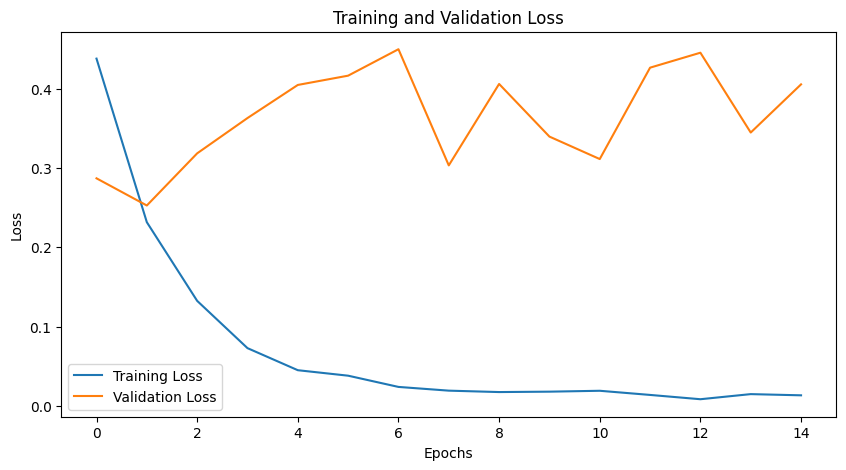

In [19]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


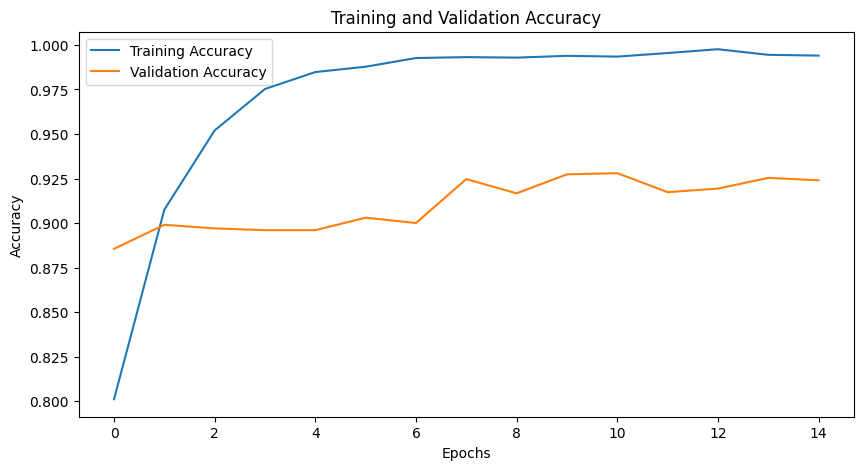

In [20]:
# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()
